# Quickview Notebook

Welcome! This IPython notebook provides a quick look at short segments of data from the <a href='https://gw-osc.org/'>Gravitational Wave Open Science Center</a>

* Set the GPS time (t0) and detector in the first cell
* Click "Run All" in the cell menu at the top
* Your plots will appear below

v0.8; April 2023

## SET PARAMETERS: Detector and GPS time

In [1]:
# -- Set a GPS time:
t0 = 1126259462.4    # -- GW150914

#-- Choose detector as H1, L1, or V1
detector = 'H1'

You might try some of these examples times in the H1 detector:
<pre>
t0 = 1126259462.4    # -- GW150914
t0 = 1187008882.4    # -- GW170817
t0 = 933200215       # -- Loud hardware injection
t0 = 1132401286.33   # -- Koi Fish Glitch
</pre>

### Import some packages

In [2]:
import requests, os
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

try:
    from gwpy.timeseries import TimeSeries
except:
    ! pip install -q "gwpy==3.0.7"
    ! pip install -q "matplotlib==3.5.3"
    ! pip install -q "astropy==6.0.0"
    from gwpy.timeseries import TimeSeries    

### Query and download data file

In [3]:
from gwosc.locate import get_urls
url = get_urls(detector, t0, t0)[-1]

print('Downloading: ' , url)
fn = os.path.basename(url)
with open(fn,'wb') as strainfile:                 
    straindata = requests.get(url)
    strainfile.write(straindata.content)

Downloading:  https://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


### Plot the raw time-series data

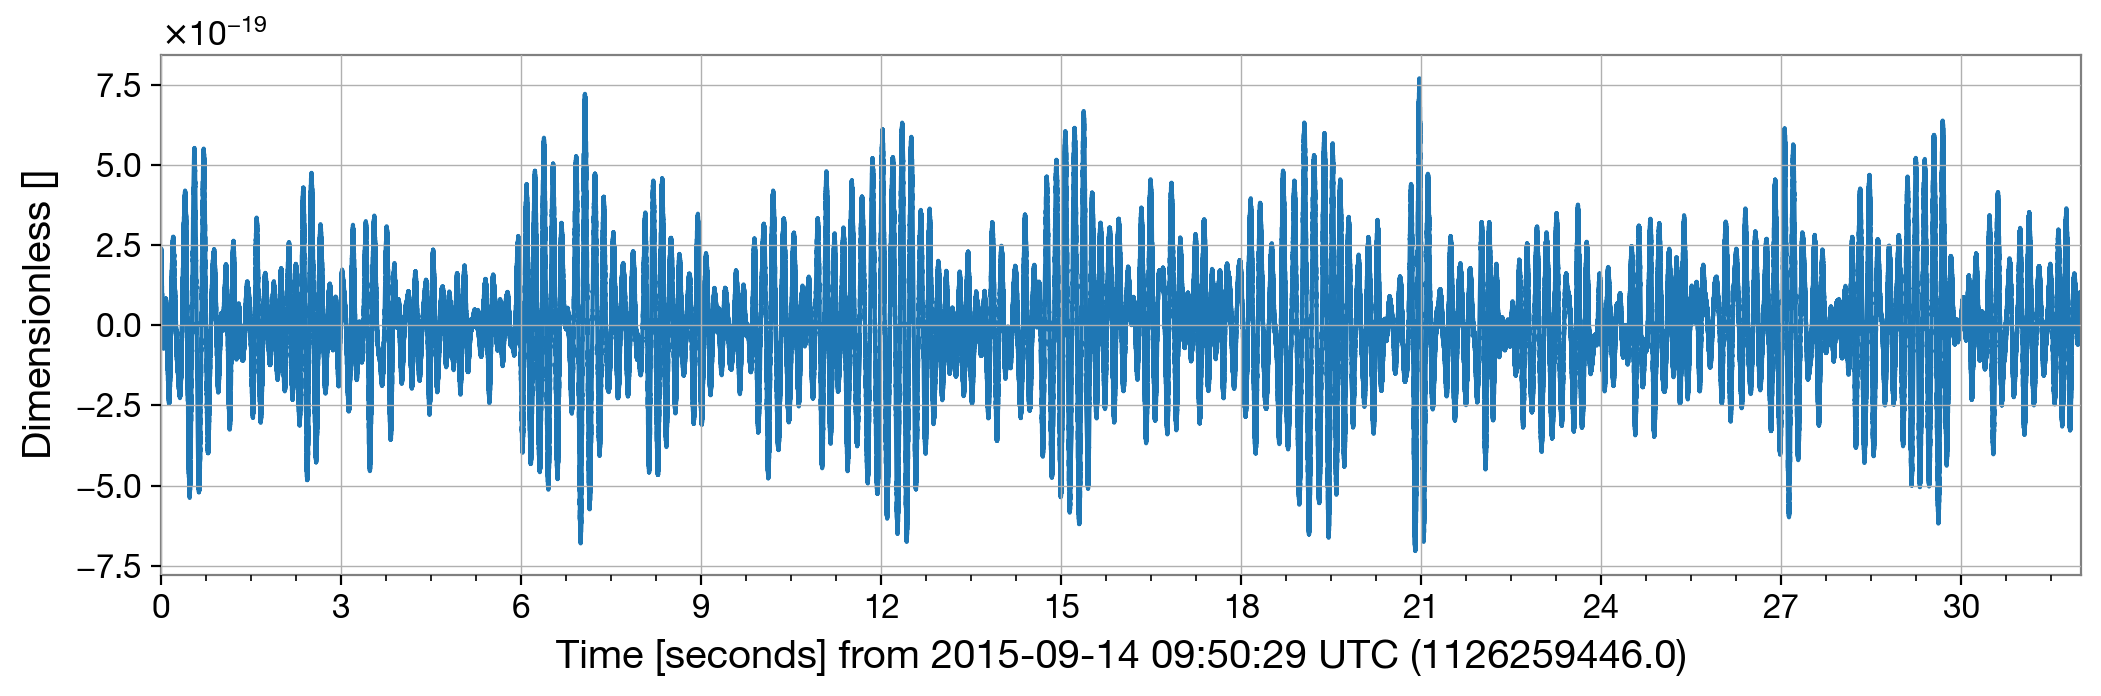

In [4]:
# -- Read strain data
strain = TimeSeries.read(fn,format='hdf5.gwosc')
center = int(t0)
strain = strain.crop(center-16, center+16)
fig1 = strain.plot()
plt.show()

### Plot the ASD

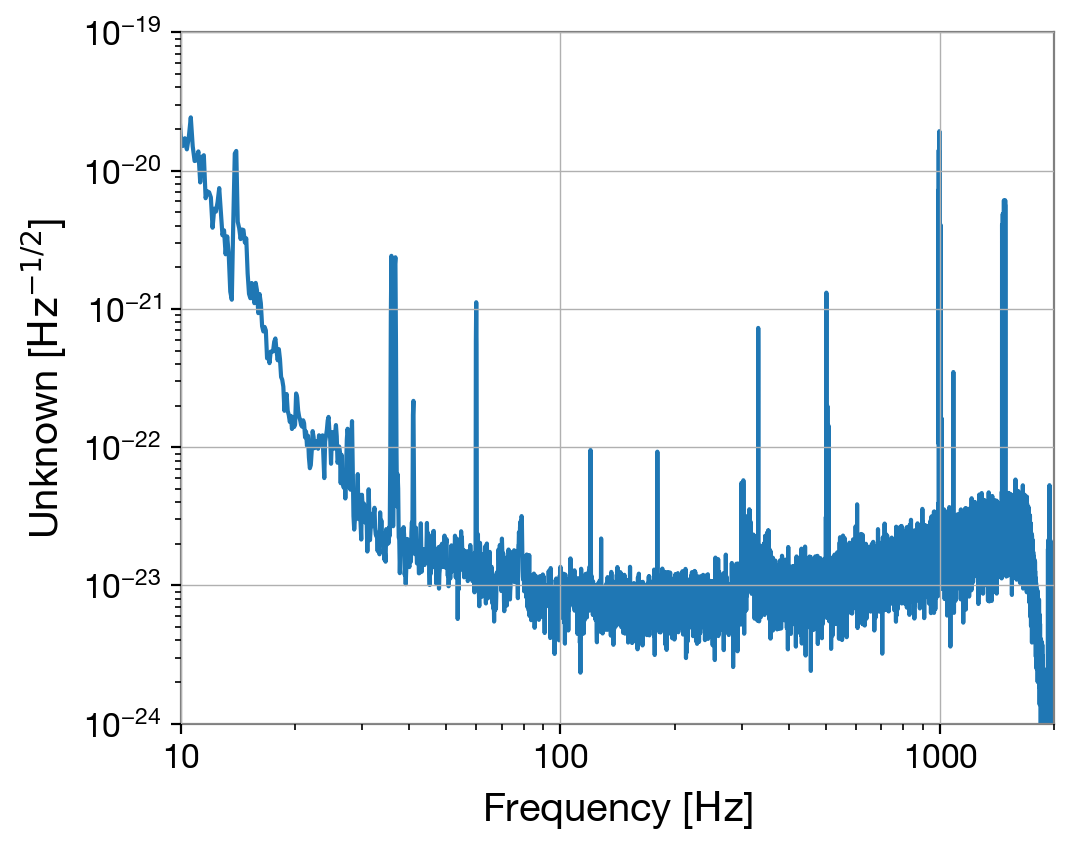

In [5]:
# -- Plot ASD
fig2 = strain.asd(fftlength=8).plot()
plt.xlim(10,2000)
plt.ylim(1e-24, 1e-19)
plt.show()

### Whiten and band-pass the data

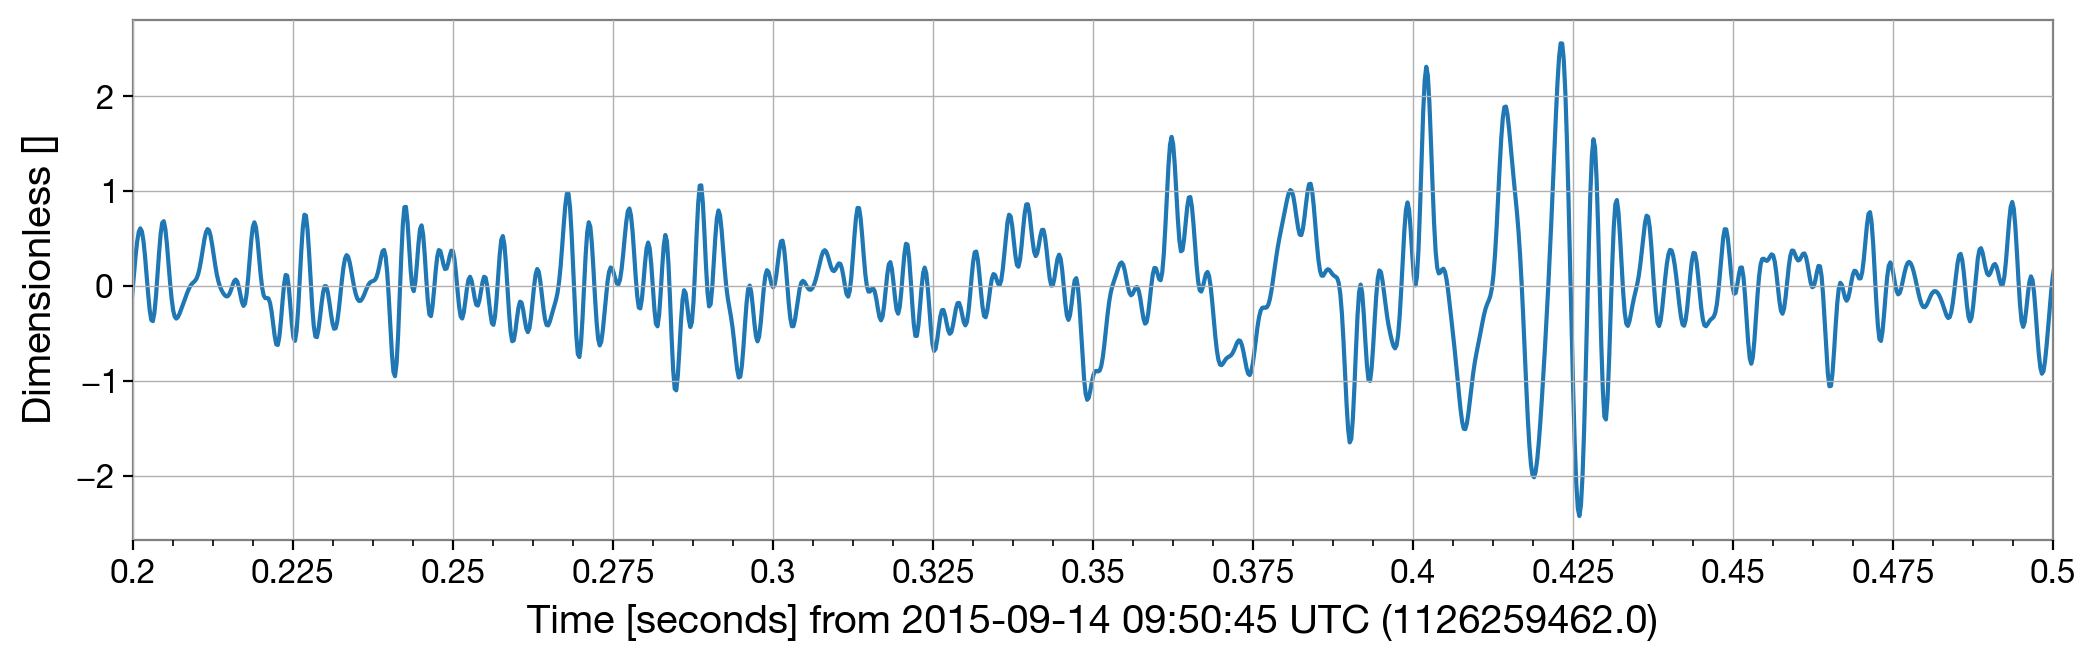

In [6]:
# -- Whiten and bandpass data
white_data = strain.whiten()
bp_data = white_data.bandpass(30, 400)
fig3 = bp_data.plot()
plt.xlim(t0-0.2, t0+0.1)
plt.show()

### Plot a q-transform of the data

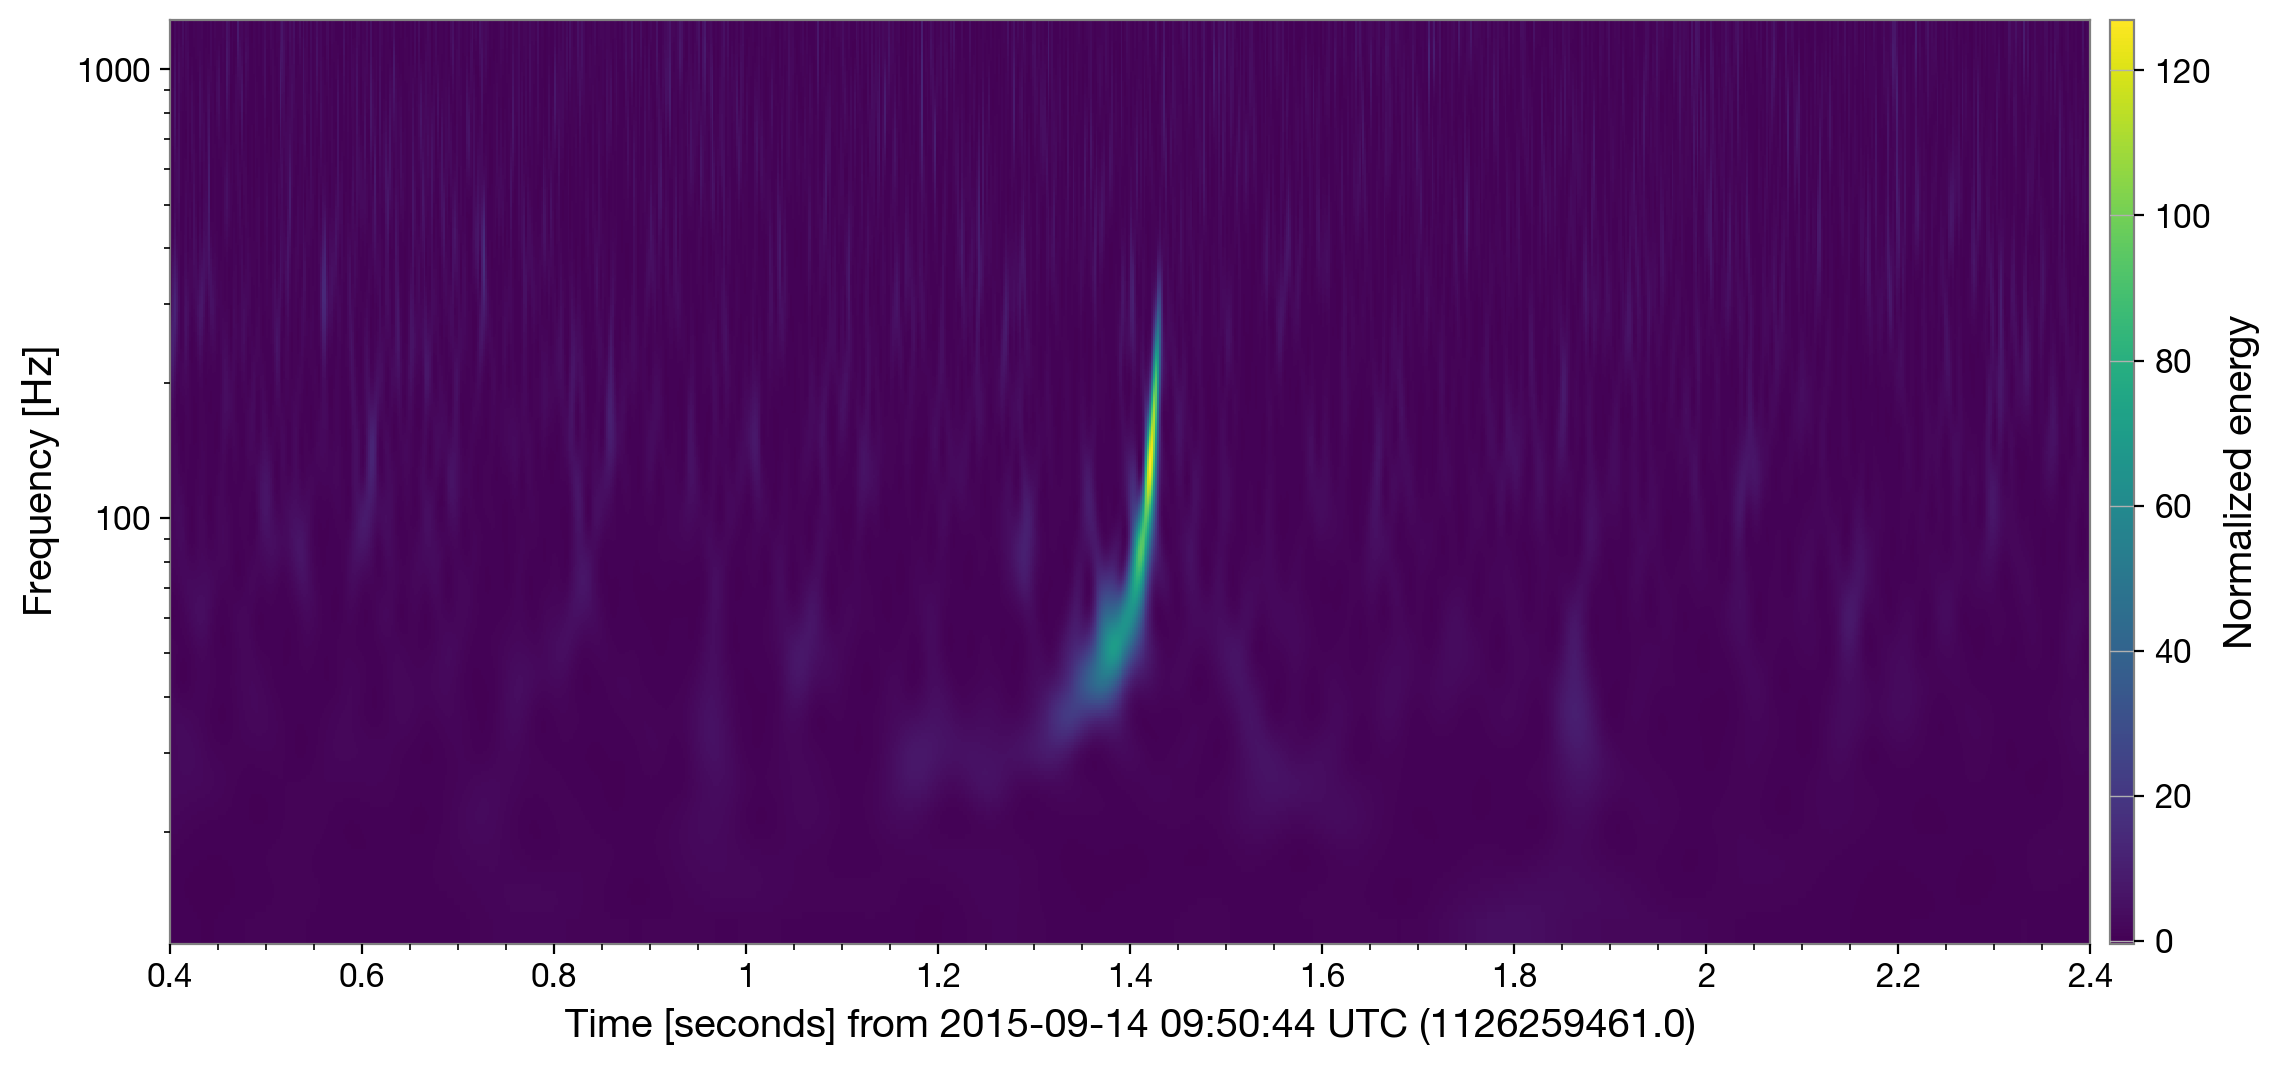

In [7]:
dt = 1  #-- Set width of q-transform plot, in seconds
hq = strain.q_transform(outseg=(t0-dt, t0+dt))
fig4 = hq.plot()
ax = fig4.gca()
ax.grid(False)
ax.set_yscale('log')
try: fig4.colorbar(label="Normalized energy")
except: pass
plt.show()